In [1]:
import os
import re
import string
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from datasets import load_dataset

/home/Sinner/miniforge3/envs/AIO2024/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/Sinner/miniforge3/envs/AIO2024/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/Sinner/miniforge3/envs/AIO2024/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarni

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super(TokenAndPositionEmbedding, self).__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.ln1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.ln2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout1= nn.Dropout(p=dropout)
        self.dropout2= nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout1(attn_output)
        out1 = self.ln1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.ln2(out1 + ffn_output)
        return out2

class TransformerEncoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_dim,
        max_length,
        num_layers,
        num_heads,
        ff_dim,
        dropout=0.1,
        device='cpu'
    ):
        super(TransformerEncoder, self).__init__()
        self.embedding = TokenAndPositionEmbedding(
            src_vocab_size,
            embed_dim,
            max_length,
            device
        )
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, 
                    num_heads,
                    ff_dim,
                    dropout
                ) for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [4]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoderBlock, self).__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.ln1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.ln2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.ln3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.ln1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out1,
            enc_output,
            enc_output,
            attn_mask=src_mask
        )
        attn_output = self.dropout2(attn_output)
        out2 = self.ln2(out1 + attn_output)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.ln3(out2 + ffn_output)
        return out3

class TransformerDecoder(nn.Module):
    def __init__(
        self,
        tgt_vocab_size,
        embed_dim,
        max_length,
        num_layers,
        num_heads,
        ff_dim,
        dropout=0.1,
        device='cpu'
    ):
        super(TransformerDecoder, self).__init__()
        self.embedding = TokenAndPositionEmbedding(
            tgt_vocab_size,
            embed_dim,
            max_length,
            device
        )
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim,
                    num_heads,
                    ff_dim,
                    dropout
                ) for _ in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

In [5]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        embed_dim,
        max_length,
        num_layers,
        num_heads,
        ff_dim,
        dropout=0.1,
        device='cpu'
    ):
        super(Transformer, self).__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            src_vocab_size,
            embed_dim,
            max_length,
            num_layers,
            num_heads,
            ff_dim
        )
        self.decoder = TransformerDecoder(
            tgt_vocab_size,
            embed_dim,
            max_length,
            num_layers,
            num_heads,
            ff_dim
        )
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device
        ).type(torch.bool)

        tgt_mask = torch.triu(torch.ones(
            (tgt_seq_len, tgt_seq_len),
            device=self.device
        ) == 1).transpose(0,1)
        tgt_mask = tgt_mask.float().masked_fill(
            tgt_mask == 0,
            float('-inf')
        ).masked_fill(tgt_mask == 1, float(0.0))
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [6]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

model = Transformer(
    src_vocab_size,
    tgt_vocab_size,
    embed_dim,
    max_length,
    num_layers,
    num_heads,
    ff_dim
)

src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

prediction = model(src, tgt)
prediction.shape

torch.Size([128, 100, 2000])

In [7]:
ds = load_dataset('thainq107/ntc-scv')

In [8]:
def preprocess_text(text):
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(r" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile ("["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F1F2-\U0001F1F4"
        u"\U0001F1E6-\U0001F1FF"
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

In [9]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

tokenizer = get_tokenizer('basic_english')

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=['<pad>','<unk>']
)
vocabulary.set_default_index(vocabulary['<unk>'])

def prepare_dataset(df):
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)

In [10]:
seq_length = 100

def collate_batch(batch):
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length
        else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [11]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                '| Epoch {:3d} | {:5d}/{:5d} batches '
                '| Accuracy {:8.3f}'.format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses =[]

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)

        print('-' * 59)
        print(
            '| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} '
            '| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} '.format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print('-' * 59)

    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [12]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(epochs, train_accs, label='Training')
    axs[0].plot(epochs, eval_accs, label='Evaluation')
    axs[1].plot(epochs, train_losses, label='Training')
    axs[1].plot(epochs, eval_losses, label='Evaluation')
    axs[0].set_xlabel('Epochs')
    axs[1].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[1].set_ylabel('Loss')
    plt.legend()

In [13]:
class TransformerEncoderCls(nn.Module):
    def __init__(
        self,
        vocab_size, 
        max_length,
        num_layers,
        embed_dim,
        num_heads,
        ff_dim,
        dropout=0.1,
        device='cpu'
    ):
        super(TransformerEncoderCls, self).__init__()
        self.encoder = TransformerEncoder(
            vocab_size,
            embed_dim,
            max_length,
            num_layers,
            num_heads,
            ff_dim,
            dropout,
            device
        )
        self.pool = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pool(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [14]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TransformerEncoderCls(
    vocab_size,
    max_length,
    num_layers,
    embed_dim,
    num_heads,
    ff_dim,
    dropout,
    device
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'model'

model, metrics = train(
    model,
    model_name,
    save_model,
    optimizer,
    criterion,
    train_dataloader,
    valid_dataloader,
    num_epochs,
    device
)

| Epoch   1 |    50/  235 batches | Accuracy    0.557


| Epoch   1 |   100/  235 batches | Accuracy    0.600


| Epoch   1 |   150/  235 batches | Accuracy    0.687


| Epoch   1 |   200/  235 batches | Accuracy    0.710


-----------------------------------------------------------
| End of epoch   1 | Time: 140.82s | Train Accuracy    0.734 | Train Loss    0.633 | Valid Accuracy    0.741 | Valid Loss    0.538 
-----------------------------------------------------------


| Epoch   2 |    50/  235 batches | Accuracy    0.766


| Epoch   2 |   100/  235 batches | Accuracy    0.787


| Epoch   2 |   150/  235 batches | Accuracy    0.790


| Epoch   2 |   200/  235 batches | Accuracy    0.798


-----------------------------------------------------------
| End of epoch   2 | Time: 141.85s | Train Accuracy    0.796 | Train Loss    0.465 | Valid Accuracy    0.795 | Valid Loss    0.448 
-----------------------------------------------------------


| Epoch   3 |    50/  235 batches | Accuracy    0.810


| Epoch   3 |   100/  235 batches | Accuracy    0.823


| Epoch   3 |   150/  235 batches | Accuracy    0.819


| Epoch   3 |   200/  235 batches | Accuracy    0.810


-----------------------------------------------------------
| End of epoch   3 | Time: 136.53s | Train Accuracy    0.816 | Train Loss    0.415 | Valid Accuracy    0.807 | Valid Loss    0.429 
-----------------------------------------------------------


| Epoch   4 |    50/  235 batches | Accuracy    0.834


| Epoch   4 |   100/  235 batches | Accuracy    0.826


| Epoch   4 |   150/  235 batches | Accuracy    0.830


| Epoch   4 |   200/  235 batches | Accuracy    0.830


-----------------------------------------------------------
| End of epoch   4 | Time: 138.74s | Train Accuracy    0.828 | Train Loss    0.390 | Valid Accuracy    0.817 | Valid Loss    0.409 
-----------------------------------------------------------


| Epoch   5 |    50/  235 batches | Accuracy    0.846


| Epoch   5 |   100/  235 batches | Accuracy    0.832


| Epoch   5 |   150/  235 batches | Accuracy    0.831


| Epoch   5 |   200/  235 batches | Accuracy    0.832


-----------------------------------------------------------
| End of epoch   5 | Time: 146.61s | Train Accuracy    0.838 | Train Loss    0.375 | Valid Accuracy    0.825 | Valid Loss    0.402 
-----------------------------------------------------------


| Epoch   6 |    50/  235 batches | Accuracy    0.844


| Epoch   6 |   100/  235 batches | Accuracy    0.843


| Epoch   6 |   150/  235 batches | Accuracy    0.835


| Epoch   6 |   200/  235 batches | Accuracy    0.850


-----------------------------------------------------------
| End of epoch   6 | Time: 144.45s | Train Accuracy    0.843 | Train Loss    0.361 | Valid Accuracy    0.829 | Valid Loss    0.394 
-----------------------------------------------------------


| Epoch   7 |    50/  235 batches | Accuracy    0.851


| Epoch   7 |   100/  235 batches | Accuracy    0.848


| Epoch   7 |   150/  235 batches | Accuracy    0.849


| Epoch   7 |   200/  235 batches | Accuracy    0.847


-----------------------------------------------------------
| End of epoch   7 | Time: 142.06s | Train Accuracy    0.858 | Train Loss    0.351 | Valid Accuracy    0.831 | Valid Loss    0.394 
-----------------------------------------------------------


| Epoch   8 |    50/  235 batches | Accuracy    0.853


| Epoch   8 |   100/  235 batches | Accuracy    0.854


| Epoch   8 |   150/  235 batches | Accuracy    0.856


| Epoch   8 |   200/  235 batches | Accuracy    0.856


-----------------------------------------------------------
| End of epoch   8 | Time: 142.38s | Train Accuracy    0.856 | Train Loss    0.341 | Valid Accuracy    0.834 | Valid Loss    0.386 
-----------------------------------------------------------


| Epoch   9 |    50/  235 batches | Accuracy    0.861


| Epoch   9 |   100/  235 batches | Accuracy    0.862


| Epoch   9 |   150/  235 batches | Accuracy    0.853


| Epoch   9 |   200/  235 batches | Accuracy    0.858


-----------------------------------------------------------
| End of epoch   9 | Time: 143.45s | Train Accuracy    0.856 | Train Loss    0.333 | Valid Accuracy    0.836 | Valid Loss    0.385 
-----------------------------------------------------------


| Epoch  10 |    50/  235 batches | Accuracy    0.867


| Epoch  10 |   100/  235 batches | Accuracy    0.862


| Epoch  10 |   150/  235 batches | Accuracy    0.870


| Epoch  10 |   200/  235 batches | Accuracy    0.861


-----------------------------------------------------------
| End of epoch  10 | Time: 142.51s | Train Accuracy    0.864 | Train Loss    0.321 | Valid Accuracy    0.839 | Valid Loss    0.380 
-----------------------------------------------------------


| Epoch  11 |    50/  235 batches | Accuracy    0.864


| Epoch  11 |   100/  235 batches | Accuracy    0.867


| Epoch  11 |   150/  235 batches | Accuracy    0.880


| Epoch  11 |   200/  235 batches | Accuracy    0.865


-----------------------------------------------------------
| End of epoch  11 | Time: 143.31s | Train Accuracy    0.862 | Train Loss    0.314 | Valid Accuracy    0.842 | Valid Loss    0.376 
-----------------------------------------------------------


| Epoch  12 |    50/  235 batches | Accuracy    0.878


| Epoch  12 |   100/  235 batches | Accuracy    0.874


| Epoch  12 |   150/  235 batches | Accuracy    0.872


| Epoch  12 |   200/  235 batches | Accuracy    0.876


-----------------------------------------------------------
| End of epoch  12 | Time: 143.92s | Train Accuracy    0.871 | Train Loss    0.306 | Valid Accuracy    0.843 | Valid Loss    0.378 
-----------------------------------------------------------


| Epoch  13 |    50/  235 batches | Accuracy    0.879


| Epoch  13 |   100/  235 batches | Accuracy    0.880


| Epoch  13 |   150/  235 batches | Accuracy    0.873


| Epoch  13 |   200/  235 batches | Accuracy    0.875


-----------------------------------------------------------
| End of epoch  13 | Time: 141.37s | Train Accuracy    0.887 | Train Loss    0.298 | Valid Accuracy    0.845 | Valid Loss    0.382 
-----------------------------------------------------------


| Epoch  14 |    50/  235 batches | Accuracy    0.875


| Epoch  14 |   100/  235 batches | Accuracy    0.873


| Epoch  14 |   150/  235 batches | Accuracy    0.884


| Epoch  14 |   200/  235 batches | Accuracy    0.886


-----------------------------------------------------------
| End of epoch  14 | Time: 140.08s | Train Accuracy    0.888 | Train Loss    0.291 | Valid Accuracy    0.844 | Valid Loss    0.388 
-----------------------------------------------------------


| Epoch  15 |    50/  235 batches | Accuracy    0.892


| Epoch  15 |   100/  235 batches | Accuracy    0.885


| Epoch  15 |   150/  235 batches | Accuracy    0.885


| Epoch  15 |   200/  235 batches | Accuracy    0.882


-----------------------------------------------------------
| End of epoch  15 | Time: 141.21s | Train Accuracy    0.890 | Train Loss    0.282 | Valid Accuracy    0.840 | Valid Loss    0.387 
-----------------------------------------------------------


| Epoch  16 |    50/  235 batches | Accuracy    0.895


| Epoch  16 |   100/  235 batches | Accuracy    0.900


| Epoch  16 |   150/  235 batches | Accuracy    0.886


| Epoch  16 |   200/  235 batches | Accuracy    0.884


-----------------------------------------------------------
| End of epoch  16 | Time: 141.41s | Train Accuracy    0.893 | Train Loss    0.274 | Valid Accuracy    0.846 | Valid Loss    0.386 
-----------------------------------------------------------


| Epoch  17 |    50/  235 batches | Accuracy    0.902


| Epoch  17 |   100/  235 batches | Accuracy    0.896


| Epoch  17 |   150/  235 batches | Accuracy    0.894


| Epoch  17 |   200/  235 batches | Accuracy    0.891


-----------------------------------------------------------
| End of epoch  17 | Time: 141.91s | Train Accuracy    0.895 | Train Loss    0.265 | Valid Accuracy    0.843 | Valid Loss    0.388 
-----------------------------------------------------------


| Epoch  18 |    50/  235 batches | Accuracy    0.905


| Epoch  18 |   100/  235 batches | Accuracy    0.900


| Epoch  18 |   150/  235 batches | Accuracy    0.891


| Epoch  18 |   200/  235 batches | Accuracy    0.904


-----------------------------------------------------------
| End of epoch  18 | Time: 142.21s | Train Accuracy    0.894 | Train Loss    0.255 | Valid Accuracy    0.843 | Valid Loss    0.391 
-----------------------------------------------------------


| Epoch  19 |    50/  235 batches | Accuracy    0.906


| Epoch  19 |   100/  235 batches | Accuracy    0.910


| Epoch  19 |   150/  235 batches | Accuracy    0.899


| Epoch  19 |   200/  235 batches | Accuracy    0.897


-----------------------------------------------------------
| End of epoch  19 | Time: 143.86s | Train Accuracy    0.901 | Train Loss    0.248 | Valid Accuracy    0.835 | Valid Loss    0.405 
-----------------------------------------------------------


| Epoch  20 |    50/  235 batches | Accuracy    0.908


| Epoch  20 |   100/  235 batches | Accuracy    0.915


| Epoch  20 |   150/  235 batches | Accuracy    0.911


| Epoch  20 |   200/  235 batches | Accuracy    0.903


-----------------------------------------------------------
| End of epoch  20 | Time: 143.59s | Train Accuracy    0.901 | Train Loss    0.236 | Valid Accuracy    0.840 | Valid Loss    0.404 
-----------------------------------------------------------


| Epoch  21 |    50/  235 batches | Accuracy    0.913


| Epoch  21 |   100/  235 batches | Accuracy    0.916


| Epoch  21 |   150/  235 batches | Accuracy    0.914


| Epoch  21 |   200/  235 batches | Accuracy    0.911


-----------------------------------------------------------
| End of epoch  21 | Time: 142.33s | Train Accuracy    0.917 | Train Loss    0.226 | Valid Accuracy    0.841 | Valid Loss    0.429 
-----------------------------------------------------------


| Epoch  22 |    50/  235 batches | Accuracy    0.918


| Epoch  22 |   100/  235 batches | Accuracy    0.921


| Epoch  22 |   150/  235 batches | Accuracy    0.910


| Epoch  22 |   200/  235 batches | Accuracy    0.915


-----------------------------------------------------------
| End of epoch  22 | Time: 144.01s | Train Accuracy    0.920 | Train Loss    0.218 | Valid Accuracy    0.838 | Valid Loss    0.435 
-----------------------------------------------------------


| Epoch  23 |    50/  235 batches | Accuracy    0.925


| Epoch  23 |   100/  235 batches | Accuracy    0.927


| Epoch  23 |   150/  235 batches | Accuracy    0.922


| Epoch  23 |   200/  235 batches | Accuracy    0.920


-----------------------------------------------------------
| End of epoch  23 | Time: 144.63s | Train Accuracy    0.923 | Train Loss    0.207 | Valid Accuracy    0.833 | Valid Loss    0.447 
-----------------------------------------------------------


| Epoch  24 |    50/  235 batches | Accuracy    0.928


| Epoch  24 |   100/  235 batches | Accuracy    0.933


| Epoch  24 |   150/  235 batches | Accuracy    0.930


| Epoch  24 |   200/  235 batches | Accuracy    0.929


-----------------------------------------------------------
| End of epoch  24 | Time: 144.22s | Train Accuracy    0.927 | Train Loss    0.195 | Valid Accuracy    0.824 | Valid Loss    0.502 
-----------------------------------------------------------


| Epoch  25 |    50/  235 batches | Accuracy    0.933


| Epoch  25 |   100/  235 batches | Accuracy    0.931


| Epoch  25 |   150/  235 batches | Accuracy    0.940


| Epoch  25 |   200/  235 batches | Accuracy    0.934


-----------------------------------------------------------
| End of epoch  25 | Time: 144.33s | Train Accuracy    0.930 | Train Loss    0.184 | Valid Accuracy    0.828 | Valid Loss    0.494 
-----------------------------------------------------------


| Epoch  26 |    50/  235 batches | Accuracy    0.944


| Epoch  26 |   100/  235 batches | Accuracy    0.939


| Epoch  26 |   150/  235 batches | Accuracy    0.933


| Epoch  26 |   200/  235 batches | Accuracy    0.942


-----------------------------------------------------------
| End of epoch  26 | Time: 143.70s | Train Accuracy    0.936 | Train Loss    0.173 | Valid Accuracy    0.824 | Valid Loss    0.513 
-----------------------------------------------------------


| Epoch  27 |    50/  235 batches | Accuracy    0.948


| Epoch  27 |   100/  235 batches | Accuracy    0.939


| Epoch  27 |   150/  235 batches | Accuracy    0.944


| Epoch  27 |   200/  235 batches | Accuracy    0.947


-----------------------------------------------------------
| End of epoch  27 | Time: 143.66s | Train Accuracy    0.945 | Train Loss    0.162 | Valid Accuracy    0.827 | Valid Loss    0.530 
-----------------------------------------------------------


| Epoch  28 |    50/  235 batches | Accuracy    0.950


| Epoch  28 |   100/  235 batches | Accuracy    0.950


| Epoch  28 |   150/  235 batches | Accuracy    0.952


| Epoch  28 |   200/  235 batches | Accuracy    0.948


-----------------------------------------------------------
| End of epoch  28 | Time: 145.32s | Train Accuracy    0.950 | Train Loss    0.150 | Valid Accuracy    0.824 | Valid Loss    0.573 
-----------------------------------------------------------


| Epoch  29 |    50/  235 batches | Accuracy    0.959


| Epoch  29 |   100/  235 batches | Accuracy    0.953


| Epoch  29 |   150/  235 batches | Accuracy    0.957


| Epoch  29 |   200/  235 batches | Accuracy    0.951


-----------------------------------------------------------
| End of epoch  29 | Time: 144.74s | Train Accuracy    0.954 | Train Loss    0.139 | Valid Accuracy    0.825 | Valid Loss    0.583 
-----------------------------------------------------------


| Epoch  30 |    50/  235 batches | Accuracy    0.963


| Epoch  30 |   100/  235 batches | Accuracy    0.958


| Epoch  30 |   150/  235 batches | Accuracy    0.957


| Epoch  30 |   200/  235 batches | Accuracy    0.959


-----------------------------------------------------------
| End of epoch  30 | Time: 144.99s | Train Accuracy    0.960 | Train Loss    0.129 | Valid Accuracy    0.824 | Valid Loss    0.633 
-----------------------------------------------------------


| Epoch  31 |    50/  235 batches | Accuracy    0.969


| Epoch  31 |   100/  235 batches | Accuracy    0.968


| Epoch  31 |   150/  235 batches | Accuracy    0.957


| Epoch  31 |   200/  235 batches | Accuracy    0.962


-----------------------------------------------------------
| End of epoch  31 | Time: 144.69s | Train Accuracy    0.964 | Train Loss    0.117 | Valid Accuracy    0.824 | Valid Loss    0.647 
-----------------------------------------------------------


| Epoch  32 |    50/  235 batches | Accuracy    0.972


| Epoch  32 |   100/  235 batches | Accuracy    0.968


| Epoch  32 |   150/  235 batches | Accuracy    0.966


| Epoch  32 |   200/  235 batches | Accuracy    0.963


-----------------------------------------------------------
| End of epoch  32 | Time: 144.90s | Train Accuracy    0.965 | Train Loss    0.109 | Valid Accuracy    0.822 | Valid Loss    0.694 
-----------------------------------------------------------


| Epoch  33 |    50/  235 batches | Accuracy    0.975


| Epoch  33 |   100/  235 batches | Accuracy    0.968


| Epoch  33 |   150/  235 batches | Accuracy    0.972


| Epoch  33 |   200/  235 batches | Accuracy    0.965


-----------------------------------------------------------
| End of epoch  33 | Time: 144.36s | Train Accuracy    0.967 | Train Loss    0.101 | Valid Accuracy    0.818 | Valid Loss    0.734 
-----------------------------------------------------------


| Epoch  34 |    50/  235 batches | Accuracy    0.977


| Epoch  34 |   100/  235 batches | Accuracy    0.973


| Epoch  34 |   150/  235 batches | Accuracy    0.973


| Epoch  34 |   200/  235 batches | Accuracy    0.974


-----------------------------------------------------------
| End of epoch  34 | Time: 146.67s | Train Accuracy    0.970 | Train Loss    0.092 | Valid Accuracy    0.819 | Valid Loss    0.786 
-----------------------------------------------------------


| Epoch  35 |    50/  235 batches | Accuracy    0.978


| Epoch  35 |   100/  235 batches | Accuracy    0.983


| Epoch  35 |   150/  235 batches | Accuracy    0.979


| Epoch  35 |   200/  235 batches | Accuracy    0.975


-----------------------------------------------------------
| End of epoch  35 | Time: 144.84s | Train Accuracy    0.973 | Train Loss    0.083 | Valid Accuracy    0.820 | Valid Loss    0.784 
-----------------------------------------------------------


| Epoch  36 |    50/  235 batches | Accuracy    0.979


| Epoch  36 |   100/  235 batches | Accuracy    0.980


| Epoch  36 |   150/  235 batches | Accuracy    0.980


| Epoch  36 |   200/  235 batches | Accuracy    0.981


-----------------------------------------------------------
| End of epoch  36 | Time: 144.70s | Train Accuracy    0.980 | Train Loss    0.076 | Valid Accuracy    0.819 | Valid Loss    0.864 
-----------------------------------------------------------


| Epoch  37 |    50/  235 batches | Accuracy    0.982


| Epoch  37 |   100/  235 batches | Accuracy    0.984


| Epoch  37 |   150/  235 batches | Accuracy    0.981


| Epoch  37 |   200/  235 batches | Accuracy    0.981


-----------------------------------------------------------
| End of epoch  37 | Time: 144.94s | Train Accuracy    0.979 | Train Loss    0.071 | Valid Accuracy    0.818 | Valid Loss    0.886 
-----------------------------------------------------------


| Epoch  38 |    50/  235 batches | Accuracy    0.981


| Epoch  38 |   100/  235 batches | Accuracy    0.985


| Epoch  38 |   150/  235 batches | Accuracy    0.985


| Epoch  38 |   200/  235 batches | Accuracy    0.983


-----------------------------------------------------------
| End of epoch  38 | Time: 155.77s | Train Accuracy    0.981 | Train Loss    0.067 | Valid Accuracy    0.820 | Valid Loss    0.900 
-----------------------------------------------------------


| Epoch  39 |    50/  235 batches | Accuracy    0.987


| Epoch  39 |   100/  235 batches | Accuracy    0.981


| Epoch  39 |   150/  235 batches | Accuracy    0.984


| Epoch  39 |   200/  235 batches | Accuracy    0.983


-----------------------------------------------------------
| End of epoch  39 | Time: 157.04s | Train Accuracy    0.982 | Train Loss    0.063 | Valid Accuracy    0.820 | Valid Loss    0.984 
-----------------------------------------------------------


| Epoch  40 |    50/  235 batches | Accuracy    0.987


| Epoch  40 |   100/  235 batches | Accuracy    0.984


| Epoch  40 |   150/  235 batches | Accuracy    0.988


| Epoch  40 |   200/  235 batches | Accuracy    0.985


-----------------------------------------------------------
| End of epoch  40 | Time: 157.46s | Train Accuracy    0.986 | Train Loss    0.056 | Valid Accuracy    0.821 | Valid Loss    1.039 
-----------------------------------------------------------


| Epoch  41 |    50/  235 batches | Accuracy    0.989


| Epoch  41 |   100/  235 batches | Accuracy    0.988


| Epoch  41 |   150/  235 batches | Accuracy    0.988


| Epoch  41 |   200/  235 batches | Accuracy    0.986


-----------------------------------------------------------
| End of epoch  41 | Time: 157.91s | Train Accuracy    0.989 | Train Loss    0.051 | Valid Accuracy    0.819 | Valid Loss    1.094 
-----------------------------------------------------------


| Epoch  42 |    50/  235 batches | Accuracy    0.989


| Epoch  42 |   100/  235 batches | Accuracy    0.990


| Epoch  42 |   150/  235 batches | Accuracy    0.989


| Epoch  42 |   200/  235 batches | Accuracy    0.986


-----------------------------------------------------------
| End of epoch  42 | Time: 158.51s | Train Accuracy    0.986 | Train Loss    0.050 | Valid Accuracy    0.813 | Valid Loss    1.197 
-----------------------------------------------------------


| Epoch  43 |    50/  235 batches | Accuracy    0.992


| Epoch  43 |   100/  235 batches | Accuracy    0.988


| Epoch  43 |   150/  235 batches | Accuracy    0.989


| Epoch  43 |   200/  235 batches | Accuracy    0.988


-----------------------------------------------------------
| End of epoch  43 | Time: 156.26s | Train Accuracy    0.992 | Train Loss    0.045 | Valid Accuracy    0.816 | Valid Loss    1.248 
-----------------------------------------------------------


| Epoch  44 |    50/  235 batches | Accuracy    0.992


| Epoch  44 |   100/  235 batches | Accuracy    0.992


| Epoch  44 |   150/  235 batches | Accuracy    0.991


| Epoch  44 |   200/  235 batches | Accuracy    0.986


-----------------------------------------------------------
| End of epoch  44 | Time: 156.87s | Train Accuracy    0.992 | Train Loss    0.042 | Valid Accuracy    0.819 | Valid Loss    1.288 
-----------------------------------------------------------


| Epoch  45 |    50/  235 batches | Accuracy    0.991


| Epoch  45 |   100/  235 batches | Accuracy    0.993


| Epoch  45 |   150/  235 batches | Accuracy    0.989


| Epoch  45 |   200/  235 batches | Accuracy    0.989


-----------------------------------------------------------
| End of epoch  45 | Time: 155.96s | Train Accuracy    0.991 | Train Loss    0.040 | Valid Accuracy    0.819 | Valid Loss    1.317 
-----------------------------------------------------------


| Epoch  46 |    50/  235 batches | Accuracy    0.993


| Epoch  46 |   100/  235 batches | Accuracy    0.991


| Epoch  46 |   150/  235 batches | Accuracy    0.990


| Epoch  46 |   200/  235 batches | Accuracy    0.992


-----------------------------------------------------------
| End of epoch  46 | Time: 154.09s | Train Accuracy    0.991 | Train Loss    0.039 | Valid Accuracy    0.819 | Valid Loss    1.320 
-----------------------------------------------------------


| Epoch  47 |    50/  235 batches | Accuracy    0.991


| Epoch  47 |   100/  235 batches | Accuracy    0.991


| Epoch  47 |   150/  235 batches | Accuracy    0.991


| Epoch  47 |   200/  235 batches | Accuracy    0.992


-----------------------------------------------------------
| End of epoch  47 | Time: 151.26s | Train Accuracy    0.992 | Train Loss    0.037 | Valid Accuracy    0.816 | Valid Loss    1.526 
-----------------------------------------------------------


| Epoch  48 |    50/  235 batches | Accuracy    0.990


| Epoch  48 |   100/  235 batches | Accuracy    0.993


| Epoch  48 |   150/  235 batches | Accuracy    0.992


| Epoch  48 |   200/  235 batches | Accuracy    0.992


-----------------------------------------------------------
| End of epoch  48 | Time: 152.25s | Train Accuracy    0.991 | Train Loss    0.036 | Valid Accuracy    0.818 | Valid Loss    1.392 
-----------------------------------------------------------


| Epoch  49 |    50/  235 batches | Accuracy    0.993


| Epoch  49 |   100/  235 batches | Accuracy    0.989


| Epoch  49 |   150/  235 batches | Accuracy    0.990


| Epoch  49 |   200/  235 batches | Accuracy    0.991


-----------------------------------------------------------
| End of epoch  49 | Time: 149.03s | Train Accuracy    0.992 | Train Loss    0.038 | Valid Accuracy    0.819 | Valid Loss    1.455 
-----------------------------------------------------------


| Epoch  50 |    50/  235 batches | Accuracy    0.994


| Epoch  50 |   100/  235 batches | Accuracy    0.990


| Epoch  50 |   150/  235 batches | Accuracy    0.991


| Epoch  50 |   200/  235 batches | Accuracy    0.992


-----------------------------------------------------------
| End of epoch  50 | Time: 144.26s | Train Accuracy    0.992 | Train Loss    0.034 | Valid Accuracy    0.813 | Valid Loss    1.616 
-----------------------------------------------------------


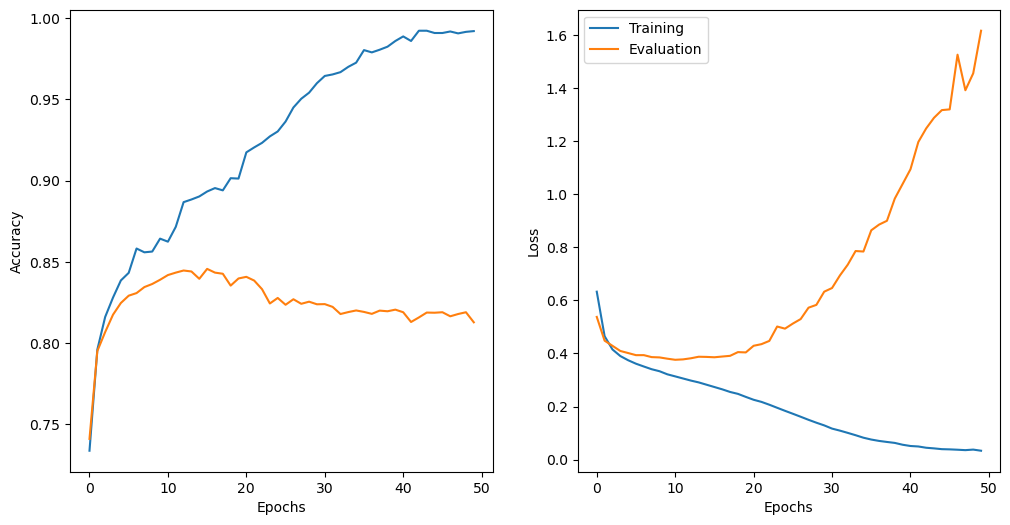

In [15]:
plot_result(num_epochs, metrics['train_accuracy'], metrics['valid_accuracy'], metrics['train_loss'], metrics['valid_loss'])